In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os

**Load and Preprocess Training Data**

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentinel2_CropSamples_Reorganized.csv')
train_df.head()


,blue,crop_type,green,nir,nir08,red,rededge1,rededge2,rededge3,swir16,swir22,time,unique_id,x,y
0,559,cocoa,771,2404,2585,846,1240,2006,2326,2630,1684,2022-01-03,PIXEL_0001,0.957526,6.899852
1,537,cocoa,916,2448,2750,1096,1464,2124,2390,2851,1823,2022-01-08,PIXEL_0001,0.957526,6.899852
2,540,cocoa,877,2402,2498,1084,1415,1943,2184,3069,2100,2022-01-23,PIXEL_0001,0.957526,6.899852
3,1944,cocoa,2094,3076,3307,2260,2537,2809,3043,3887,2979,2022-01-28,PIXEL_0001,0.957526,6.899852
4,2062,cocoa,2092,2484,2599,2210,2293,2371,2529,2837,2275,2022-02-12,PIXEL_0001,0.957526,6.899852


In [5]:
test_df = pd.read_csv('/content/drive/MyDrive/test (6).csv')
test_df.head()

,unique_id,time,x,y,red,nir,swir16,swir22,blue,green,rededge1,rededge2,rededge3,nir08
0,ID_01FHV4,2018-01-03 10:59:22.851,-296455.0,846395.0,0.2920,0.3686,0.4173,0.3869,0.2488,0.2708,0.3211,0.3555,0.3752,0.3862
1,ID_01FHV4,2018-01-03 10:59:22.851,-296455.0,846395.0,0.2920,0.3686,0.4173,0.3869,0.2488,0.2708,0.3211,0.3555,0.3752,0.3862
2,ID_01FHV4,2018-02-12 10:59:25.232,-296455.0,846395.0,0.3510,0.3426,0.4817,0.4577,0.2538,0.2914,0.3684,0.3484,0.3588,0.3628
3,ID_01FHV4,2018-02-12 10:59:25.232,-296455.0,846395.0,0.3510,0.3426,0.4817,0.4577,0.2538,0.2914,0.3684,0.3484,0.3588,0.3628
4,ID_01FHV4,2018-03-14 10:59:24.436,-296455.0,846395.0,0.5312,0.6296,0.6643,0.5882,0.5244,0.5308,0.6016,0.6217,0.6401,0.6404


In [6]:
train_df['crop_type'].value_counts()

,count
crop_type,
cocoa,6359
rubber,6283
oil,5800


In [7]:
train_df['time'] = pd.to_datetime(train_df['time'])


In [8]:
#first  we will Calculate NDVI (Normalized Difference Vegetation Index)
# NDVI = (NIR - RED) / (NIR + RED)
# now we are adding a small epsilon (1e-6) to the denominator to prevent division by zero errors
train_df['ndvi'] = (train_df['nir'] - train_df['red']) / (train_df['nir'] + train_df['red'] + 1e-6)


In [9]:
# now we define the features to aggregate (all spectral bands + NDVI)
# We will exclude 'system:index', 'x', 'y', '.geo' as they are not direct features for classification after aggregation
features_to_aggregate = [
    'blue', 'green', 'nir', 'nir08', 'red', 'rededge1', 'rededge2', 'rededge3', 'swir16', 'swir22', 'ndvi'
]


In [10]:
test_df["timestamp"] = pd.to_datetime(test_df["time"])

In [11]:
# Grouping by 'unique_id' and 'crop_type' and performing mean pooling for the features
# We are doing grouping by crop_type as well to keep the target variable associated with each unique_id
aggregated_df = train_df.groupby(['unique_id', 'crop_type'])[features_to_aggregate].mean().reset_index()

print("\nAggregated DataFrame (Mean Pooled Features):")
print(aggregated_df.head())
print("\nAggregated DataFrame Info:")
aggregated_df.info()


Aggregated DataFrame (Mean Pooled Features):
    unique_id crop_type         blue        green          nir        nir08  \
0  PIXEL_0001     cocoa  1803.111111  2043.462963  3656.018519  3942.259259   
1  PIXEL_0002     cocoa  1610.305556  1858.851852  3621.805556  3902.416667   
2  PIXEL_0003     cocoa  1610.910714  1895.232143  3948.857143  4161.419643   
3  PIXEL_0004     cocoa  1641.381818  1871.018182  3445.818182  3744.345455   
4  PIXEL_0005     cocoa  1659.913043  1835.434783  4272.369565  4423.978261   

           red     rededge1     rededge2     rededge3       swir16  \
0  2115.185185  2542.351852  3349.481481  3670.351852  3931.518519   
1  1839.694444  2359.231481  3294.370370  3617.851852  3677.000000   
2  1816.517857  2389.089286  3493.928571  3887.580357  3502.419643   
3  1888.454545  2345.672727  3132.709091  3436.090909  3623.345455   
4  1732.413043  2181.543478  3559.869565  4145.565217  3222.413043   

        swir22      ndvi  
0  3077.944444  0.267227  
1  2

In [12]:
# Let's see the distribution of crop types in the aggregated data
print("\nCrop Type Distribution (Aggregated Data):")
print(aggregated_df['crop_type'].value_counts())


Crop Type Distribution (Aggregated Data):
crop_type
cocoa     100
rubber    100
oil       100
Name: count, dtype: int64


In [13]:
# 'unique_id' is just an identifier, not a feature for the model
X = aggregated_df.drop(['unique_id', 'crop_type'], axis=1)
y = aggregated_df['crop_type']

In [14]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [15]:
# Get the mapping from numerical labels back to crop names
crop_classes = label_encoder.classes_
print(f"\nEncoded Crop Types: {list(enumerate(crop_classes))}")


Encoded Crop Types: [(0, 'cocoa'), (1, 'oil'), (2, 'rubber')]


In [16]:
from sklearn.preprocessing import  StandardScaler

In [17]:
    scaler = StandardScaler()
    X_train_scaled_full = scaler.fit_transform(X)

    print("Training data preprocessing complete.")
    print(f"Shape of full training features: {X.shape}")


Training data preprocessing complete.
Shape of full training features: (300, 11)


In [18]:
test_df['ndvi'] = (test_df['nir'] - test_df['red']) / (test_df['nir'] + test_df['red'] + 1e-6)

In [19]:
aggregated_df_test = test_df.groupby('unique_id')[features_to_aggregate].mean().reset_index()

In [20]:
    X_test_for_prediction = aggregated_df_test.drop('unique_id', axis=1)

    # Scaling of the test features using scaler fitted
    X_test_scaled_for_prediction = scaler.transform(X_test_for_prediction)

    print(aggregated_df_test.head())
    print(f"\nShape of test features for prediction: {X_test_for_prediction.shape}")

   unique_id      blue     green       nir     nir08       red  rededge1  \
0  ID_002AIV  0.584356  0.575075  0.678630  0.700476  0.552039  0.609075   
1  ID_0042EI  0.536195  0.525035  0.636570  0.661719  0.504694  0.548404   
2  ID_008SD4  0.557038  0.544186  0.646852  0.667090  0.520859  0.573803   
3  ID_00AQE9  0.482738  0.479424  0.586478  0.612003  0.467276  0.516267   
4  ID_00F4A9  0.583594  0.564251  0.650874  0.685945  0.546873  0.591151   

   rededge2  rededge3    swir16    swir22      ndvi  
0  0.665725  0.689273  0.459119  0.369510  0.178821  
1  0.609446  0.645887  0.470162  0.381506  0.180023  
2  0.622829  0.651830  0.464463  0.382437  0.169235  
3  0.566692  0.591748  0.471859  0.376031  0.175648  
4  0.642767  0.675590  0.484421  0.390951  0.154630  

Shape of test features for prediction: (10523, 11)


**training of Models on Full Training Data**

In [21]:
from sklearn.linear_model import LogisticRegression

***model 1***

In [22]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled_full, y_encoded )

LogisticRegression(max_iter=1000, random_state=42)

***model 2***

In [23]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X, y_encoded)

RandomForestClassifier(class_weight='balanced', random_state=42)

***model 3***

In [24]:
from sklearn.neural_network import MLPClassifier

In [25]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64,),
    max_iter=500,
    random_state=42,
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate_init=0.001,
    early_stopping=True,
    n_iter_no_change=10
)
mlp_model.fit(X_train_scaled_full,y_encoded)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(64,), max_iter=500,
              random_state=42)

**Generating Predictions**

In [26]:
lr_pred_proba = lr_model.predict_proba(X_test_scaled_for_prediction)
lr_pred_df = pd.DataFrame(lr_pred_proba, columns=[f"LR_{c}_prob" for c in crop_classes])
lr_pred_df['ID'] = aggregated_df_test['unique_id']
# Reordering of columns to match desired output: ID, cocoa, oil, rubber
lr_pred_df = lr_pred_df[['ID'] + [f"LR_{c}_prob" for c in ['cocoa', 'oil', 'rubber']]] # Ensure order if class_names is not naturally sorted
print("\nLogistic Regression Predictions (first 5 rows):")
print(lr_pred_df.head())


Logistic Regression Predictions (first 5 rows):
          ID  LR_cocoa_prob  LR_oil_prob  LR_rubber_prob
0  ID_002AIV       0.891196     0.065029        0.043775
1  ID_0042EI       0.891178     0.065291        0.043532
2  ID_008SD4       0.891269     0.062990        0.045741
3  ID_00AQE9       0.891232     0.064351        0.044417
4  ID_00F4A9       0.891110     0.059991        0.048899


In [27]:
rf_pred_proba = rf_model.predict_proba(X_test_for_prediction) # RF uses unscaled data
rf_pred_df = pd.DataFrame(rf_pred_proba, columns=[f"RF_{c}_prob" for c in crop_classes])
rf_pred_df['ID'] = aggregated_df_test['unique_id']
rf_pred_df = rf_pred_df[['ID'] + [f"RF_{c}_prob" for c in ['cocoa', 'oil', 'rubber']]]
print("\nRandom Forest Predictions (first 5 rows):")
print(rf_pred_df.head())


Random Forest Predictions (first 5 rows):
          ID  RF_cocoa_prob  RF_oil_prob  RF_rubber_prob
0  ID_002AIV           0.27         0.52            0.21
1  ID_0042EI           0.27         0.52            0.21
2  ID_008SD4           0.27         0.52            0.21
3  ID_00AQE9           0.27         0.52            0.21
4  ID_00F4A9           0.27         0.52            0.21


In [28]:
mlp_pred_proba = mlp_model.predict_proba(X_test_scaled_for_prediction)
mlp_pred_df = pd.DataFrame(mlp_pred_proba, columns=[f"MLP_{c}_prob" for c in crop_classes])
mlp_pred_df['ID'] = aggregated_df_test['unique_id']
mlp_pred_df = mlp_pred_df[['ID'] + [f"MLP_{c}_prob" for c in ['cocoa', 'oil', 'rubber']]]
print("\nMLP Classifier Predictions (first 5 rows):")
print(mlp_pred_df.head())


MLP Classifier Predictions (first 5 rows):
          ID  MLP_cocoa_prob  MLP_oil_prob  MLP_rubber_prob
0  ID_002AIV        0.999869      0.000060         0.000070
1  ID_0042EI        0.999869      0.000060         0.000071
2  ID_008SD4        0.999873      0.000060         0.000068
3  ID_00AQE9        0.999871      0.000060         0.000070
4  ID_00F4A9        0.999877      0.000059         0.000064


In [29]:
lr_output_filename = 'logistic_regression_predictions01.csv'
lr_pred_df.to_csv(lr_output_filename, index=False)
print(f"Logistic Regression predictions saved to '{lr_output_filename}'")

Logistic Regression predictions saved to 'logistic_regression_predictions01.csv'


In [30]:
rf_output_filename = 'random_forest_predictions01.csv'
rf_pred_df.to_csv(rf_output_filename, index=False)
print(f"Random Forest predictions saved to '{rf_output_filename}'")

Random Forest predictions saved to 'random_forest_predictions01.csv'


In [31]:
mlp_output_filename = 'mlp_predictions01.csv'
mlp_pred_df.to_csv(mlp_output_filename, index=False)
print(f"MLP Classifier predictions saved to '{mlp_output_filename}'")

MLP Classifier predictions saved to 'mlp_predictions01.csv'


1. Model Evaluation
Validation Split: Currently, you seem to train and evaluate on the full dataset. Consider using a train/validation split or cross-validation to estimate model performance before predicting on the test set.
Metrics: Evaluate each model on metrics such as accuracy, F1-score, confusion matrix, or ROC-AUC (for multi-class, use macro/micro averaging).
2. Feature Importance & Selection
Feature Importance: For Random Forest, check .feature_importances_ to see which bands or indices are most important. This can guide further feature engineering.
Additional Indices: Besides NDVI, consider adding other indices (EVI, NDWI, etc.) if relevant to your crop types.
3. Ensemble or Stacking
Since you have three models, you could try a simple ensemble (e.g., averaging probabilities) or use a meta-learner (stacking) for potentially better results.
4. Data Leakage Check
Ensure there’s no leakage between train and test, especially if aggregating by unique_id.
5. Hyperparameter Tuning
You use default or basic hyperparameters. Try GridSearchCV or RandomizedSearchCV on your models for better performance.
6. Reproducibility & Documentation
Set all random seeds.
Add comments/cell markdown to document your rationale for each step (you’ve already done this to a good extent).

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train models on X_train, y_train (do this for all models)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(scaler.fit_transform(X_train), y_train)
y_pred_lr = lr_model.predict(scaler.transform(X_val))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

mlp_model = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42, early_stopping=True)
mlp_model.fit(scaler.fit_transform(X_train), y_train)
y_pred_mlp = mlp_model.predict(scaler.transform(X_val))

# Evaluate each model
print("Logistic Regression:")
print(classification_report(y_val, y_pred_lr, target_names=crop_classes))
print("\nRandom Forest:")
print(classification_report(y_val, y_pred_rf, target_names=crop_classes))
print("\nMLP Classifier:")
print(classification_report(y_val, y_pred_mlp, target_names=crop_classes))

Logistic Regression:
              precision    recall  f1-score   support

       cocoa       0.44      0.35      0.39        20
         oil       0.36      0.40      0.38        20
      rubber       0.41      0.45      0.43        20

    accuracy                           0.40        60
   macro avg       0.40      0.40      0.40        60
weighted avg       0.40      0.40      0.40        60


Random Forest:
              precision    recall  f1-score   support

       cocoa       0.25      0.25      0.25        20
         oil       0.39      0.35      0.37        20
      rubber       0.23      0.25      0.24        20

    accuracy                           0.28        60
   macro avg       0.29      0.28      0.29        60
weighted avg       0.29      0.28      0.29        60


MLP Classifier:
              precision    recall  f1-score   support

       cocoa       0.29      0.35      0.32        20
         oil       0.43      0.30      0.35        20
      rubber       0.

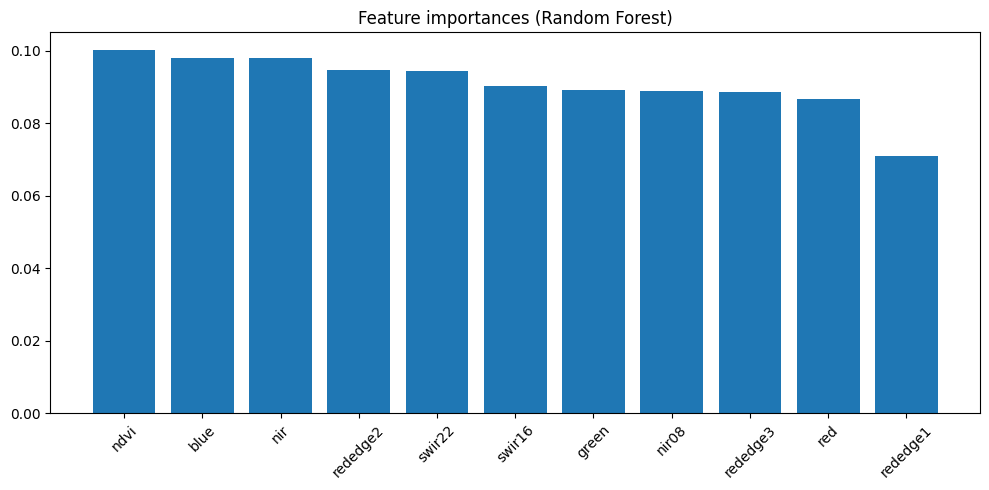

In [33]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title("Feature importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Ensure probability DataFrames have the same order and unique_id
ensemble_pred_df = lr_pred_df.copy()
ensemble_pred_df['ENS_cocoa_prob'] = (lr_pred_df['LR_cocoa_prob'] + rf_pred_df['RF_cocoa_prob'] + mlp_pred_df['MLP_cocoa_prob']) / 3
ensemble_pred_df['ENS_oil_prob'] = (lr_pred_df['LR_oil_prob'] + rf_pred_df['RF_oil_prob'] + mlp_pred_df['MLP_oil_prob']) / 3
ensemble_pred_df['ENS_rubber_prob'] = (lr_pred_df['LR_rubber_prob'] + rf_pred_df['RF_rubber_prob'] + mlp_pred_df['MLP_rubber_prob']) / 3

ensemble_output_filename = 'ensemble_predictions01.csv'
ensemble_pred_df[['ID', 'ENS_cocoa_prob', 'ENS_oil_prob', 'ENS_rubber_prob']].to_csv(ensemble_output_filename, index=False)
print(f"Ensemble predictions saved to '{ensemble_output_filename}'")

Ensemble predictions saved to 'ensemble_predictions01.csv'


In [35]:
leak_ids = set(aggregated_df['unique_id']).intersection(set(aggregated_df_test['unique_id']))
if leak_ids:
    print(f"Warning: Data leakage detected for these IDs: {leak_ids}")
else:
    print("No data leakage detected between train and test unique_ids.")

No data leakage detected between train and test unique_ids.


In [36]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_macro',
    cv=3,
    random_state=42,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)
print("Best Random Forest params:", rf_search.best_params_)
print("Best cross-validated F1-macro score:", rf_search.best_score_)

Best Random Forest params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Best cross-validated F1-macro score: 0.355846793706541


In [37]:
# Retrain Random Forest on the full training set with best params
best_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)
best_rf_model.fit(X, y_encoded)

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       n_estimators=300, random_state=42)

In [38]:
# Predict probabilities for test set
rf_test_pred_proba = best_rf_model.predict_proba(X_test_for_prediction)

In [39]:
import numpy as np

# Average the probabilities
ensemble_test_pred_proba = (
    lr_pred_proba + rf_test_pred_proba + mlp_pred_proba
) / 3

# (Optional) Get predicted class by highest probability
ensemble_test_pred = np.argmax(ensemble_test_pred_proba, axis=1)

In [40]:
ensemble_pred_df = pd.DataFrame(
    ensemble_test_pred_proba,
    columns=[f"Ensemble_{c}_prob" for c in crop_classes]
)
ensemble_pred_df['ID'] = aggregated_df_test['unique_id']
ensemble_pred_df = ensemble_pred_df[['ID'] + [f"Ensemble_{c}_prob" for c in ['cocoa', 'oil', 'rubber']]]

ensemble_output_filename = 'ensemble_predictions_final.csv'
ensemble_pred_df.to_csv(ensemble_output_filename, index=False)
print(f"Ensemble predictions saved to '{ensemble_output_filename}'")

Ensemble predictions saved to 'ensemble_predictions_final.csv'
